In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

In [166]:
ROOT = '/home/robert/Projects/NCAA2021'
Train = pd.read_csv(f'{ROOT}/Data/Train.csv')
TeamIDs = pd.read_csv(f'{ROOT}/Data/MTeams.csv')
Rankings = pd.read_csv(f'{ROOT}/Data/MMasseyOrdinals.csv')
Train.drop(columns=['Unnamed: 0'], inplace=True)
CURRENT_YEAR = 2022
Train

,Season,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,...,Team1 DR,Team2 DR,Team1 DR A,Team2 DR A,Team1 TO,Team2 TO,Team1 TA,Team2 TA,Team1 Pts,Team2 Pts
0,2003,1104,68,1328,62,27,58,3,14,11,...,24.966667,23.928571,22.400000,22.642857,11.800000,13.285714,13.700000,13.857143,62,68
1,2003,1272,70,1393,63,26,62,8,20,10,...,25.965517,26.896552,23.586207,22.275862,13.793103,13.620690,15.068966,14.448276,70,63
2,2003,1266,73,1437,61,24,58,8,18,17,...,23.700000,24.071429,22.900000,18.571429,16.033333,13.571429,16.966667,12.500000,61,73
3,2003,1296,56,1457,50,18,38,3,9,17,...,22.645161,23.964286,20.096774,23.821429,17.000000,14.642857,14.451613,15.642857,56,50
4,2003,1400,77,1208,71,30,61,6,14,11,...,26.142857,24.592593,22.000000,23.740741,13.428571,11.555556,14.178571,13.444444,77,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100418,2022,1400,79,1242,76,28,67,3,20,20,...,24.695652,22.416667,20.173913,19.750000,12.695652,10.958333,12.739130,14.791667,76,79
100419,2022,1411,66,1126,63,24,59,2,20,16,...,21.454545,24.900000,24.863636,21.750000,12.772727,14.300000,12.909091,11.650000,63,66
100420,2022,1422,68,1441,49,23,56,13,32,9,...,24.708333,23.434783,26.333333,20.478261,12.291667,12.913043,9.916667,11.608696,49,68
100421,2022,1438,69,1181,68,31,65,2,12,5,...,21.083333,26.782609,20.875000,21.739130,9.333333,10.434783,10.375000,11.695652,69,68


In [167]:
def get_team_name(team_id):
    return TeamIDs.loc[TeamIDs['TeamID']==team_id]['TeamName'].values[0]

In [168]:
def get_team_id(team_name):
    return TeamIDs.loc[TeamIDs['TeamName']==team_name]['TeamID'].values[0]

## Find and Fix Skewed Features

In [169]:
for col in Train.columns:
    skew = Train[col].skew()
    if abs(skew) > 1:
        print(f'{col}: {round(skew, 3)}')

This makes sense, stats like score per game, win%, etc. are expected for fall into a normal distribution. However, the team ranks are an average of polls, rankings, etc. so, they won't fall into a normal distribution.

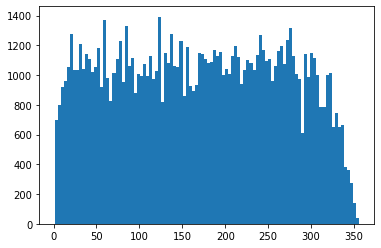

In [170]:
plt.hist(Train['Team1 Rank'], bins=100)
plt.show()

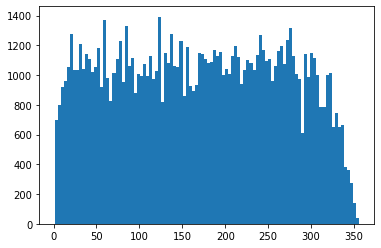

In [171]:
plt.hist(Train['Team1 Rank'], bins=100)
plt.show()

## Scale & Split Data

In [172]:
scale_columns = []
features = []
predict = ['Team1 Pts', 'Team2 Pts']
no_scale = ['Season', 'Team1', 'Team2', 'Team1 Pts', 'Team2 Pts']
for col in Train.columns:
    if col not in no_scale and ('Team1' in col or 'Team2' in col):
        features.append(col)
        scale_columns.append(col)
scaler = MinMaxScaler()
Train[scale_columns] = scaler.fit_transform(Train[scale_columns])

In [173]:
X_train = Train[Train.Season < CURRENT_YEAR]
X_train = X_train[features]
y_train = Train[Train.Season < CURRENT_YEAR]
y_train = y_train[predict]
X_test = Train[Train.Season == CURRENT_YEAR]
X_test = X_test[features]
y_test = Train[Train.Season == CURRENT_YEAR]
y_test = y_test[predict]

In [174]:
svr = SVR()
regr = MultiOutputRegressor(svr)
regr.fit(X_train, y_train)
X_test

,Team1 Rank,Team2 Rank,Team1 Win%,Team2 Win%,Team1 Avg Pts,Team2 Avg Pts,Team1 Avg Pts A,Team2 Avg Pts A,Team1 Fg%,Team2 Fg%,...,Team1 OR A,Team2 OR A,Team1 DR,Team2 DR,Team1 DR A,Team2 DR A,Team1 TO,Team2 TO,Team1 TA,Team2 TA
96687,0.256009,0.039819,0.700000,0.608696,0.581062,0.668889,0.405444,0.526110,0.542345,0.472425,...,0.354226,0.455574,0.605355,0.606182,0.460387,0.392988,0.251963,0.393307,0.371596,0.335923
96688,0.874034,0.941257,0.363636,0.238095,0.422748,0.188125,0.465760,0.362787,0.430696,0.160681,...,0.242406,0.369381,0.458877,0.403268,0.342990,0.542254,0.418450,0.433233,0.314341,0.395258
96689,0.610595,0.894552,0.380952,0.272727,0.435928,0.311839,0.373750,0.477177,0.481189,0.512745,...,0.254694,0.203308,0.557325,0.346423,0.469316,0.407810,0.315256,0.327141,0.252184,0.227672
96690,0.012201,0.838362,0.909091,0.285714,0.775103,0.360867,0.307834,0.530226,0.679125,0.301383,...,0.426165,0.197351,0.882741,0.581491,0.254161,0.489437,0.406275,0.385405,0.351110,0.117365
96691,0.375981,0.680410,0.333333,0.454545,0.322823,0.438452,0.408633,0.459101,0.222386,0.370259,...,0.447204,0.340150,0.530139,0.605932,0.662978,0.482234,0.273805,0.397144,0.345732,0.282825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100418,0.017179,0.061056,0.826087,0.750000,0.664195,0.419476,0.373230,0.112250,0.735549,0.540338,...,0.294763,0.245990,0.592392,0.447824,0.234538,0.212148,0.355460,0.239129,0.333411,0.452006
100419,0.925236,0.585218,0.227273,0.500000,0.236265,0.401842,0.399165,0.324863,0.302076,0.414863,...,0.316692,0.272511,0.386791,0.605355,0.482234,0.317782,0.360621,0.462887,0.343231,0.270481
100420,0.756872,0.476345,0.333333,0.565217,0.468060,0.304628,0.598000,0.291330,0.260529,0.389305,...,0.324837,0.118993,0.593196,0.512408,0.559859,0.250612,0.328409,0.370016,0.170330,0.268095
100421,0.222725,0.025502,0.625000,0.826087,0.307014,0.667950,0.197714,0.304070,0.553303,0.681751,...,0.210150,0.399477,0.363243,0.724779,0.271567,0.317208,0.130320,0.204072,0.196812,0.273119


In [180]:
def get_winner(team1_name, team2_name, year):
    team1 = get_team_id(team1_name)
    team2 = get_team_id(team2_name)
    team1_cols = []
    team2_cols = []
    for col in X_train.columns:
        if 'Team1' in col:
            team1_cols.append(col)
        else:
            team2_cols.append(col)
    row1 = []
    row2 = []
    return_row = []
    #check tha team1 and team2 have data for that year
    if (team1 not in Train['Team1'].values) and (team1 not in Train['Team2'].values):
        print("Can't find team1 data")
        raise IndexError
    if (team2 not in Train['Team1'].values) and (team2 not in Train['Team2'].values):
        print("Can't find team2 data")
        raise IndexError
    for col in team1_cols:
        try:
            row1.append(Train[Train.Season==year].loc[Train['Team1']==team1][col].values[0])
        except IndexError:
            row1.append(Train[Train.Season==year].loc[Train['Team2']==team1][col].values[0])
    for col in team2_cols:
        try:
            row2.append(Train[Train.Season==year].loc[Train['Team1']==team2][col].values[0])
        except IndexError:
            row2.append(Train[Train.Season==year].loc[Train['Team2']==team2][col].values[0])
    count = 0
    for i in range(len(row1)):
        return_row.append(row1[count])
        return_row.append(row2[count])
        count += 1
    df = pd.DataFrame([return_row], columns=X_train.columns)
    prediction = regr.predict(df)
    prediction = pd.DataFrame(prediction, columns=['Team1', 'Team2'])
    if prediction['Team1'].values[0] > prediction['Team2'].values[0]:
        return team1_name, f"+{round((prediction['Team1'].values[0]-prediction['Team2'].values[0]) * 2 / 2)}, {prediction['Team1'].values[0]}"
    else:
        return team2_name, f"+{round((prediction['Team2'].values[0]-prediction['Team1'].values[0]) * 2 / 2)}, {prediction['Team1'].values[0]}"

In [253]:
get_winner("Gonzaga", "Arizona", 2022)

('Gonzaga', '+23, 85.48871726582952')

In [190]:
TeamIDs

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2022
1,1102,Air Force,1985,2022
2,1103,Akron,1985,2022
3,1104,Alabama,1985,2022
4,1105,Alabama A&M,2000,2022
...,...,...,...,...
367,1468,Bellarmine,2021,2022
368,1469,Dixie St,2021,2022
369,1470,Tarleton St,2021,2022
370,1471,UC San Diego,2021,2022
